In [3]:
import os, time, sys
from pathlib import Path
import sqlite3
import cv2
import numpy as np
from matplotlib import pyplot as plt

ROOT = Path().absolute().parent
GROUND_TRUTH_PATH = Path(f"{ROOT}/data/3_results/FINAL/RatehausKoepenickShort_Raw")
COMPARISON_PATH = Path(f"{ROOT}/data/3_results/FINAL/SuperGlue_RatehausKoepenickShort_AgfaIsolette")
RELATIVE_IMAGE_PATH_NAME = "image_path"

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

COLMAP_PY_SCRIPTS_PATH = f"{ROOT}/third_party/colmap/scripts/python"
if COLMAP_PY_SCRIPTS_PATH not in sys.path:
    sys.path.append(COLMAP_PY_SCRIPTS_PATH)

In [4]:
from read_write_model import read_model, qvec2rotmat

# cameras, images, points3D
r1_info = read_model(f"{GROUND_TRUTH_PATH}/sparse", ".bin")
r2_info = read_model(f"{COMPARISON_PATH}/sparse", ".bin")
r1_cams, r1_imgs, r1_pts = r1_info
r2_cams, r2_imgs, r2_pts = r2_info

# https://colmap.github.io/format.html
# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: 3

# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: 2, mean observations per image: 2

# 3D point list with one line of data per point:
#   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
# Number of points: 3, mean track length: 3.3334

# load databases
r1_conn = sqlite3.connect(f"{GROUND_TRUTH_PATH}/database.db")
r1_cursor = r1_conn.cursor()
r2_conn = sqlite3.connect(f"{COMPARISON_PATH}/database.db")
r2_cursor = r2_conn.cursor()

#r1_cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
#print(r1_cursor.fetchall())

In [5]:
# init Colmap db reader functions from https://github.com/colmap/colmap/blob/main/scripts/python/database.py#L412
from database import pair_id_to_image_ids, image_ids_to_pair_id

# Note that COLMAP supports:
#      - 2D keypoints: (x, y)
#      - 4D keypoints: (x, y, theta, scale)
#      - 6D affine keypoints: (x, y, a_11, a_12, a_21, a_22)
# in the db each table has rows and columns! rows = number of entries, columns = format of entry (2D, 4D, 6D)
# e.g.: 1800 rows and 4 cols = 1800 entries of type 4D (x, y, theta, scale)

def name_part(full_name):
    split_name = full_name.split(".")
    if len(split_name) == 0:
        return full_name
    return split_name[0]

def read_image_by_id(cursor, img_id, path):
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.image_id = {img_id}")
    image_data = cursor.fetchone()
    if not image_data: return None
    image_name, width, height = image_data
    return cv2.imread(f"{path}/{RELATIVE_IMAGE_PATH_NAME}/{image_name}")

def read_image_by_name(cursor, img_name, path):
    name_only = name_part(img_name)
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.name LIKE '{name_only}%'")
    image_data = cursor.fetchone()
    if not image_data: return None
    image_name, width, height = image_data
    return cv2.imread(f"{path}/{RELATIVE_IMAGE_PATH_NAME}/{image_name}")

def get_image_id_from_name(cursor, img_name):
    name_only = name_part(img_name)
    cursor.execute(f"SELECT image_id FROM images WHERE name LIKE '{name_only}%'")
    image_data = cursor.fetchone()
    if not image_data: return None
    return image_data[0]

def get_image_name_from_id(cursor, img_id):
    cursor.execute(f"SELECT name FROM images WHERE image_id={img_id};")
    image_data = cursor.fetchone()
    if not image_data: return None
    img_name, = image_data
    return name_part(img_name)
    
def get_keypoints(cursor, img_id):
    cursor.execute(f"SELECT image_id, rows, cols, data FROM keypoints WHERE image_id={img_id}")
    result = cursor.fetchone()
    if not result: return None

    image_id, rows, cols, data = result
    if not data:
        return None
    dtype=np.float32
    shape=(-1, cols)
    coordinates = np.frombuffer(data, dtype=dtype).reshape(*shape)
    return {
        "image_id": int(image_id),
        "coordinates": coordinates
    }

# Get all matches
def get_all_matches(cursor):
    matches = []
    for pair_id, rows, cols, data in cursor.execute(f"SELECT pair_id, rows, cols, data FROM matches"):
        img1_id, img2_id = pair_id_to_image_ids(pair_id)
        image_matches = []
        if data:
            dtype=np.uint32
            shape=(-1, cols)
            image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": int(pair_id),
            "image1_id": int(img1_id),
            "image2_id": int(img2_id),
            "image_matches": image_matches
        })
    return matches

# Get matches for image pair
def get_matches(cursor, img1_id, img2_id):
    pair_id = image_ids_to_pair_id(img1_id, img2_id)
    cursor.execute(f"SELECT pair_id, rows, cols, data FROM matches WHERE pair_id={pair_id}")
    result = cursor.fetchone()
    if not result: return None
    
    _, rows, cols, data = result
    if not data: return None
    dtype=np.uint32
    shape=(-1, cols)
    image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
    return {
        "pair_id": int(pair_id),
        "image1_id": int(img1_id),
        "image2_id": int(img2_id),
        "image_matches": image_matches
    }

# Get the matches that are of good enough quality
def get_inlier_matches(cursor, img1_id, img2_id):
    pair_id = image_ids_to_pair_id(img1_id, img2_id)
    cursor.execute(f"SELECT pair_id, rows, cols, data FROM two_view_geometries WHERE pair_id={pair_id};")
    result = cursor.fetchone()
    if not result: return None
    
    _, rows, cols, data = result
    if not data: return None
    dtype=np.uint32
    shape=(-1, cols)
    image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
    return {
        "pair_id": int(pair_id),
        "image1_id": int(img1_id),
        "image2_id": int(img2_id),
        "image_matches": image_matches
    }

# Get the matches that are of not good enough quality
def get_outlier_matches(cursor, img1_id, img2_id):
    all_matches = get_matches(cursor, img1_id, img2_id)
    inlier_matches = get_inlier_matches(cursor, img1_id, img2_id)
    if not inlier_matches or not all_matches: return []
    
    outlier_matches = {
        "pair_id": all_matches["pair_id"],
        "image1_id": all_matches["image1_id"],
        "image2_id": all_matches["image2_id"],
        "image_matches": []
    }
    
    for match in all_matches["image_matches"]:
        if any((im == match).all() for im in inlier_matches["image_matches"]):
            continue
        outlier_matches["image_matches"].append(match)
    
    return outlier_matches

# get coordinates of matches
def get_matches_coords(cursor, matches):
    ret = []
    skipped_kps = []

    img1_kps = get_keypoints(cursor, matches["image1_id"])
    img2_kps = get_keypoints(cursor, matches["image2_id"])
    
    new_matches = dict(matches) # copy instance
    new_matches["image_matches"] = [] # clear old matches to be replaced by coords
    for im_m in matches["image_matches"]:
        img1_kp_index = im_m[0]
        img2_kp_index = im_m[1]
        img1_kp_coords = img1_kps["coordinates"]
        img2_kp_coords = img2_kps["coordinates"]
        img1_kp_coords_len = img1_kp_coords.shape[0]
        img2_kp_coords_len = img2_kp_coords.shape[0]

        # filter out matches that cannot be accessed
        # TODO: how do I properly get them?? This cannot be the ways??
        if img1_kp_index >= img1_kp_coords_len or img2_kp_index >= img2_kp_coords_len:
            skipped_kps.append((img1_kp_index, img2_kp_index))
            continue

        im_m_coords = [
            img1_kp_coords[img1_kp_index],
            img2_kp_coords[img2_kp_index]
        ]
        new_matches["image_matches"].append(im_m_coords)

    if len(skipped_kps) != 0: print(f"skipped keypoints: {len(skipped_kps)}")
    return new_matches

In [6]:
# TEST
#print(get_keypoints(r1_cursor, 1))

# Data Analysis and Comparison

In [7]:
# Collect /Aggregate Useful Info
from tabulate import tabulate
from colorama import  Back, Style, Fore
import statistics

def read_mean_reprojection_error(model_points):
    errors = np.asarray([p[1].error for p in model_points.items()])
    return round(np.nanmean(errors), 2)

def read_mean_track_length(model_points):
    # get number of images the points occured
    tracks = np.asarray([ len(p[1].image_ids) for p in model_points.items()])
    return round(np.nanmean(tracks), 2)

def get_percentage(part, total):
    if total == 0: return ""
    ret = int(round((part/total)*100, 0))
    if abs(ret) > 100:
        color = Back.MAGENTA
    elif abs(ret) > 50:
        color = Back.LIGHTBLUE_EX
    elif abs(ret) > 30:
        color = Back.BLUE
    else: color = ""
    return f"{color}{'+' if ret > 0 else ''}{ret}%{Style.RESET_ALL}"

def get_kp_per_image(cursor):
    table = []
    for image_id, name, camera_id, kp_amount, in cursor.execute("SELECT i.image_id, i.name, i.camera_id, k.rows FROM images i, keypoints k WHERE i.image_id=k.image_id"):
        table.append([
            int(image_id),
            str(name_part(name)),
            camera_id,
            kp_amount
        ])
    #return tabulate(table, headers=['Img', 'Cam ID', 'Keypoints'], tablefmt='plain', showindex="always")
    return (table, ['Img ID', 'Img Name', 'Cam ID', 'Keypoints'])

def get_matches_per_image_pairs(cursor, im_max = None, im_min = None, im_med = None):
    table = []
    for i, md in enumerate(get_all_matches(cursor)):
        rows, = cursor.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        matches = len(md['image_matches'])
        matches_ratio = int(round((rows[0]/matches) * 100, 0)) if matches > 0 else 0
        if matches_ratio == 0:
            matches_ratio_color = Back.LIGHTRED_EX
        elif matches_ratio < 50:
            matches_ratio_color = Back.RED
        elif matches_ratio < 75:
            matches_ratio_color = Back.YELLOW
        elif matches_ratio < 90:
            matches_ratio_color = Back.GREEN
        else:
            matches_ratio_color = Back.LIGHTGREEN_EX

        inlier_matches = int(rows[0])
        if im_max and int(im_max) == inlier_matches:
            im_matches_color = Back.GREEN
        elif im_min and int(im_min) == inlier_matches:
            im_matches_color = Back.RED
        elif im_med and int(im_med) == inlier_matches:
            im_matches_color = Back.BLUE
        else: im_matches_color = ""

        table.append([
            f"{Back.BLACK if md['image1_id']%2 == 0 else Back.LIGHTBLACK_EX}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}",
            md['pair_id'],
            matches,
            f"{im_matches_color}{inlier_matches}{Style.RESET_ALL}",
            f"{matches_ratio_color}{matches_ratio}%{Style.RESET_ALL}"
        ])
    # returns tuple(table_body, table_headers)
    return (table, ['Img Pair', 'Img Pair ID', 'Feature Matches', 'Inlier Matches', 'Ratio'])

def get_inlier_matches_per_image_median(cursor):
    #inlier_matches = get_inlier_matches(cursor)
    #inlier_matches = [im['image_matches'].shape[0] for im in inlier_matches]
    inlier_matches = cursor.execute("SELECT rows FROM two_view_geometries")
    inlier_matches = [im[0] for im in cursor.fetchall()]
    return statistics.median(inlier_matches)


def run_sfm_analysis(cursor, points_model):
    cursor.execute("SELECT SUM(rows) FROM keypoints")
    total_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM images")
    total_images, = cursor.fetchall()[0]
    avg_kp_per_image = round(total_keypoints/total_images, 2)
    cursor.execute("SELECT MIN(rows) FROM keypoints")
    min_keypoints, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM keypoints")
    max_keypoints, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM matches")
    total_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM matches")
    total_image_pair_matches, = cursor.fetchall()[0]
    avg_matches_per_image_pair = round(total_match_amount/total_image_pair_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM matches")
    min_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM matches")
    max_matches, = cursor.fetchall()[0]
    
    cursor.execute("SELECT SUM(rows) FROM two_view_geometries")
    total_inlier_match_amount, = cursor.fetchall()[0]
    cursor.execute("SELECT COUNT(*) FROM two_view_geometries")
    total_image_pair_inlier_matches, = cursor.fetchall()[0]
    avg_inlier_matches_per_image_pair = round(total_inlier_match_amount/total_image_pair_inlier_matches, 2)
    cursor.execute("SELECT MIN(rows) FROM two_view_geometries")
    min_inlier_matches, = cursor.fetchall()[0]
    cursor.execute("SELECT MAX(rows) FROM two_view_geometries")
    max_inlier_matches, = cursor.fetchall()[0]
    imm_p_im = get_inlier_matches_per_image_median(cursor)
    
    return {
        "images": {
            "sum": total_images
        },
        "keypoints": {
            "min": min_keypoints,
            "max": max_keypoints,
            "avg": avg_kp_per_image,
            "sum": total_keypoints
        },
        "matches": {
            "min": min_matches,
            "max": max_matches,
            "avg": avg_matches_per_image_pair,
            "sum": total_match_amount
        },
        "inlier_matches": {
            "min": min_inlier_matches,
            "max": max_inlier_matches,
            "avg": avg_inlier_matches_per_image_pair,
            "med": imm_p_im,
            "sum": total_inlier_match_amount,
            "ratio": round(total_inlier_match_amount / total_match_amount, 2) # il matches / matches ratio
        },
        "extra": {
            "avg_track_length": read_mean_track_length(points_model),
            "avg_error": read_mean_reprojection_error(points_model)
        },
        "keypoints_table": get_kp_per_image(cursor),
        "matches_table": get_matches_per_image_pairs(cursor, im_max=max_inlier_matches, im_min=min_inlier_matches, im_med=imm_p_im)
    }

def pprint_sfm_analysis(analysis_result):
    table = []
    headers = ["Metric Name", "Value", "Unit"]
    table.append(["Total Features Found", analysis_result['keypoints']['sum'], None])
    #print(f"Total Features Found: {analysis_result['keypoints']['sum']}")
    table.append(["Total Images", analysis_result['images']['sum'], None])
    #print(f"Total Images: {analysis_result['images']['sum']}")
    table.append(["Avg. Features/Image", analysis_result['keypoints']['avg'], None])
    #print(f"Avg. Features/Image: {analysis_result['keypoints']['avg']}")
    table.append(["Lowest Features/Image", analysis_result['keypoints']['min'], None])
    #print(f"Lowest Features/Image: {analysis_result['keypoints']['min']}")
    table.append(["Highest Features/Image", analysis_result['keypoints']['max'], None])
    #print(f"Highest Features/Image: {analysis_result['keypoints']['max']}")
    #print("\n")

    table.append(["Total Feature Matches", analysis_result['matches']['sum'], None])
    #print(f"Total Feature Matches: {analysis_result['matches']['sum']}")
    table.append(["Avg. Feature Matches/Image Pair", analysis_result['matches']['avg'], None])
    #print(f"Avg. Feature Matches/Image Pair: {analysis_result['matches']['avg']}")
    table.append(["Lowest Feature Matches/Image Pair", analysis_result['matches']['min'], None])
    #print(f"Lowest Feature Matches/Image Pair: {analysis_result['matches']['min']}")
    table.append(["Highest Feature Matches/Image Pair", analysis_result['matches']['max'], None])
    #print(f"Highest Feature Matches/Image Pair: {analysis_result['matches']['max']}")
    #print("\n")

    table.append(["Total Inlier Feature Matches", analysis_result['inlier_matches']['sum'], None])
    #print(f"Total Inlier Feature Matches: {analysis_result['inlier_matches']['sum']}")
    table.append(["Avg. Inlier Feature Matches", analysis_result['inlier_matches']['avg'], None])
    #print(f"Avg. Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['avg']}")
    # Median, because we might have a lot of outliers which might affect the result!
    table.append(["Median Inlier Feature Matches", analysis_result['inlier_matches']['med'], None])
    #print(f"Median for Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['med']}")
    table.append(["Lowest Inlier Feature Matches", analysis_result['inlier_matches']['min'], None])
    #print(f"Lowest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['min']}")
    table.append(["Highest Inlier Feature Matches", analysis_result['inlier_matches']['max'], None])
    #print(f"Highest Feature Inlier Matches/Image Pair: {analysis_result['inlier_matches']['max']}")
    table.append(["Inlier Matches Ratio/Matches", int(analysis_result['inlier_matches']['ratio']*100), "%"])
    #print(f"Inlier Matches Ratio/Matches: {int(analysis_result['inlier_matches']['ratio']*100)} %")
    #print("\n")

    table.append(["Avg. Track Length", analysis_result['extra']['avg_track_length'], "Images"])
    #print(f"Avg. Track Length (Images): {analysis_result['extra']['avg_track_length']}")
    table.append(["Avg. Reprojection Error", analysis_result['extra']['avg_error'], "px"])
    #print(f"Avg. Reprojection Error (px): {analysis_result['extra']['avg_error']}")
    #print("\n")

    print("General Metrics ")
    print(
        tabulate(table, headers, tablefmt='plain', showindex="always")
    )
    print("\n")
    
    print("Images ")
    print(
        tabulate(*(analysis_result['keypoints_table']), tablefmt='plain', showindex="always")
    )
    print("\n")
    
    print("Feature Matches ")
    print(
        tabulate(*(analysis_result['matches_table']), tablefmt='plain', showindex="always")
    )
    return

def run_r1_sfm_analysis():
    analysis_result = run_sfm_analysis(r1_cursor, r1_pts)
    pprint_sfm_analysis(analysis_result)
    return analysis_result

def run_r2_sfm_analysis():
    analysis_result = run_sfm_analysis(r2_cursor, r2_pts)
    pprint_sfm_analysis(analysis_result)
    return analysis_result
    
run_r1_sfm_analysis()

General Metrics 
    Metric Name                             Value  Unit
 0  Total Features Found                261287
 1  Total Images                            21
 2  Avg. Features/Image                  12442.2
 3  Lowest Features/Image                10263
 4  Highest Features/Image               15705
 5  Total Feature Matches                36371
 6  Avg. Feature Matches/Image Pair        244.1
 7  Lowest Feature Matches/Image Pair       15
 8  Highest Feature Matches/Image Pair    2563
 9  Total Inlier Feature Matches         31555
10  Avg. Inlier Feature Matches            211.78
11  Median Inlier Feature Matches           24
12  Lowest Inlier Feature Matches            0
13  Highest Inlier Feature Matches        2510
14  Inlier Matches Ratio/Matches            87     %
15  Avg. Track Length                        3.55  Images
16  Avg. Reprojection Error                  4.25  px


Images 
      Img ID  Img Name      Cam ID    Keypoints
 0         1  IMG_1141           1     

{'images': {'sum': 21},
 'keypoints': {'min': 10263, 'max': 15705, 'avg': 12442.24, 'sum': 261287},
 'matches': {'min': 15, 'max': 2563, 'avg': 244.1, 'sum': 36371},
 'inlier_matches': {'min': 0,
  'max': 2510,
  'avg': 211.78,
  'med': 24,
  'sum': 31555,
  'ratio': 0.87},
 'extra': {'avg_track_length': 3.55, 'avg_error': 4.25},
 'keypoints_table': ([[1, 'IMG_1141', 1, 14080],
   [2, 'IMG_1145', 1, 14510],
   [3, 'IMG_1149', 1, 14359],
   [4, 'IMG_1152', 1, 11801],
   [5, 'IMG_1157', 1, 13644],
   [6, 'IMG_1160', 1, 11018],
   [7, 'IMG_1163', 1, 11087],
   [8, 'IMG_1167', 1, 14095],
   [9, 'IMG_1172', 1, 10459],
   [10, 'IMG_1177', 1, 10503],
   [11, 'IMG_1181', 1, 12345],
   [12, 'IMG_1190', 1, 15064],
   [13, 'IMG_1193', 1, 12392],
   [14, 'IMG_1197', 1, 12801],
   [15, 'IMG_1201', 1, 12691],
   [16, 'IMG_1204', 1, 15705],
   [17, 'IMG_1208', 1, 11111],
   [18, 'IMG_1218', 1, 10263],
   [19, 'IMG_1221', 2, 12547],
   [20, 'IMG_1224', 1, 10411],
   [21, 'IMG_1231', 1, 10401]],
  ['Im

In [8]:
import json
import math

def rotation_matrix(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s], [s, c]])
    
def euclidean_distance(pos1, pos2):
    # Calculate the squared differences for each dimension
    squared_diffs = [(pos1[i] - pos2[i]) ** 2 for i in range(3)]
    # Sum the squared differences and take the square root
    distance = math.sqrt(sum(squared_diffs))
    return distance

def extract_position(transform_matrix):
    # Extract the position from the last column of the matrix
    position = [transform_matrix[i][3] for i in range(3)]
    return position

def get_formatted_signed_number(n):
    if n > 0:
        return f"{Back.GREEN}+{n}{Style.RESET_ALL}"
    elif n < 0:
        return f"{Back.RED}{n}{Style.RESET_ALL}"
    else:
        return f"{n}"

def compare_sfm_analysis_results(r1_result, r2_result):
    table = []
    header = ['Metric', 'R1', 'R2', 'Diff', 'Diff Rel']

    kp_sum_diff = r2_result['keypoints']['sum'] - r1_result['keypoints']['sum']
    table.append([
        "Keypoints",
        r1_result['keypoints']['sum'],
        r2_result['keypoints']['sum'],
        get_formatted_signed_number(kp_sum_diff),
        get_percentage(kp_sum_diff, r1_result['keypoints']['sum'])
    ])
    kp_avg_diff = r2_result['keypoints']['avg'] - r1_result['keypoints']['avg']
    table.append([
        "Avg. Keypoints/Image",
        r1_result['keypoints']['avg'],
        r2_result['keypoints']['avg'],
        get_formatted_signed_number(round(kp_avg_diff, 2)),
        get_percentage(kp_avg_diff, r1_result['keypoints']['avg'])
    ])
    
    match_sum_diff = r2_result['matches']['sum'] - r1_result['matches']['sum']
    table.append([
        "Matches",
        r1_result['matches']['sum'],
        r2_result['matches']['sum'],
        get_formatted_signed_number(match_sum_diff),
        get_percentage(match_sum_diff, r1_result['matches']['sum'])
    ])
    match_avg_diff = r2_result['matches']['avg'] - r1_result['matches']['avg']
    table.append([
        "Avg. Matches/Image Pair",
        r1_result['matches']['avg'],
        r2_result['matches']['avg'],
        get_formatted_signed_number(round(match_avg_diff, 2)),
        get_percentage(match_avg_diff, r1_result['matches']['avg'])
    ])

    il_match_sum_diff = r2_result['inlier_matches']['sum'] - r1_result['inlier_matches']['sum']
    table.append([
        "Inlier Matches",
        r1_result['inlier_matches']['sum'],
        r2_result['inlier_matches']['sum'],
        get_formatted_signed_number(il_match_sum_diff),
        get_percentage(il_match_sum_diff, r1_result['inlier_matches']['sum'])
    ])
    
    il_match_avg_diff = r2_result['inlier_matches']['avg'] - r1_result['inlier_matches']['avg']
    table.append([
        "Avg. Inlier Matches/Image Pair",
        r1_result['inlier_matches']['avg'],
        r2_result['inlier_matches']['avg'],
        get_formatted_signed_number(il_match_avg_diff),
        get_percentage(il_match_avg_diff, r1_result['inlier_matches']['avg'])
    ])

    il_match_med_diff = r2_result['inlier_matches']['med'] - r1_result['inlier_matches']['med']
    table.append([
        "Median Inlier Matches/Image Pair",
        r1_result['inlier_matches']['med'],
        r2_result['inlier_matches']['med'],
        get_formatted_signed_number(il_match_med_diff),
        get_percentage(il_match_med_diff, r1_result['inlier_matches']['med'])
    ])

    avg_track_length_diff = r2_result['extra']['avg_track_length'] - r1_result['extra']['avg_track_length']
    table.append([
        "Avg. Track Length",
        r1_result['extra']['avg_track_length'],
        r2_result['extra']['avg_track_length'],
        get_formatted_signed_number(avg_track_length_diff),
        get_percentage(avg_track_length_diff, r1_result['extra']['avg_track_length'])
    ])

    avg_error_diff = r2_result['extra']['avg_error'] - r1_result['extra']['avg_error']
    table.append([
        "Avg. Reprojection Error",
        r1_result['extra']['avg_error'],
        r2_result['extra']['avg_error'],
        get_formatted_signed_number(avg_error_diff),
        get_percentage(avg_error_diff, r1_result['extra']['avg_error'])
    ])
    
    print(
        tabulate(table, header, tablefmt='plain', showindex=False, numalign="right")
    )
    return

def compare_reconstructions_directly(cursor1, cursor2):
    r1_result = run_sfm_analysis(cursor1)
    r2_result = run_sfm_analysis(cursor2)
    assert r1_result['images']['sum'] == r2_result['images']['sum']
    
    compare_reconstructions(r1_result, r2_result)
    print("\n")

    kp_images_results_table = [
        [
            f"Img #{i+1}", 
            e[2], 
            r2_result['keypoints_table'][0][i][2],
            get_formatted_signed_number(r2_result['keypoints_table'][0][i][2] - e[2]),
            get_percentage(r2_result['keypoints_table'][0][i][2] - e[2], e[2])
        ]
        for i, e in enumerate(r1_result['keypoints_table'][0])
    ]
    print(
        tabulate(kp_images_results_table, ['Img', 'R1 KP', 'R2 KP', 'Diff', 'Diff'], tablefmt='plain', showindex=True)
    )
    print("\n")

    """
    matches_images_results_table = [
        [
            f"Img Pair {e[0]} {r2_result['matches_table'][0][i][0]}", 
            e[1], 
            r2_result['matches_table'][0][i][1],
            get_formatted_signed_number(r2_result['matches_table'][0][i][1] - e[1]),
            get_percentage(r2_result['matches_table'][0][i][1] - e[1], e[1])
        ]
        for i, e in enumerate(r1_result['matches_table'][0])
    ]
    """
    matches_images_results_table = []
    for i, md in enumerate(get_all_matches(cursor1)):
        cursor1.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        rows1, = cursor1.fetchone()
        matches1 = md['image_matches'].shape[0]
        matches_ratio1 = int(round((rows1/matches1) * 100, 0))
        inlier_matches1 = int(rows1)

        cursor2.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={md['pair_id']}")
        result = cursor2.fetchone()
        rows2 = 0
        # in case there are no inlier matches!
        if result:
            rows2 = result[0]
        
        cursor2.execute(f"SELECT rows FROM matches WHERE pair_id={md['pair_id']}")
        result = cursor2.fetchone()
        matches2 = 0
        # in case there are no matches
        if result:
            matches2 = result[0]
        matches_ratio2 = int(round((rows2/matches2) * 100, 0)) if matches2 != 0 else 0
        inlier_matches2 = int(rows2)

        is_selected_match = (md['image1_id'] == image1_id and md['image2_id'] == image2_id) or (md['image2_id'] == image1_id and md['image1_id'] == image2_id)
        if is_selected_match:
            image_pair_string = f"{Back.YELLOW}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}"
        else:
            image_pair_string = f"{Back.BLACK if md['image1_id']%2 == 0 else Back.LIGHTBLACK_EX}{md['image1_id']} / {md['image2_id']}{Style.RESET_ALL}"

        matches_images_results_table.append([
            image_pair_string,
            matches1,
            matches2,
            get_formatted_signed_number(matches2 - matches1),
            get_percentage(matches2 - matches1, matches1),
            "No Inlier Matches" if inlier_matches1 == 0 else inlier_matches1,
            "No Inlier Matches" if inlier_matches2 == 0 else inlier_matches2,
            get_formatted_signed_number(inlier_matches2 - inlier_matches1),
            get_percentage(inlier_matches2 - inlier_matches1, inlier_matches1),
            f"{matches_ratio1}%",
            f"{matches_ratio2}%",
            f"{get_formatted_signed_number(matches_ratio2 - matches_ratio1)}%"
        ])
    print(
        tabulate(matches_images_results_table, ['Img Pair', 'R1 M', 'R2 M', 'M Diff', 'M Diff', 'R1 IL M', 'R2 IL M', 'IL M Diff', 'IL M Diff', 'R1 M Ratio', 'R2 M Ratio', 'M Ratio Diff'], tablefmt='plain', showindex=True)
    )
    print("\n")

    table, header = compare_pose_estimation_frames(f"{GROUND_TRUTH_PATH}/transforms_withpoints.json", f"{comparison_path}/transforms_withpoints.json")
    print(
        tabulate(table, header, tablefmt='plain', showindex=True)
    )
    
    # TODO: camera pose estimation comparison and graphs
    # TODO: Reprojection Error!
    # TODO: Renaming der Dateien damit vergleich passieren kann!
    return

r1_result = run_sfm_analysis(r1_cursor, r1_pts)
r2_result = run_sfm_analysis(r2_cursor, r2_pts)

compare_sfm_analysis_results(r1_result, r2_result)

Metric                                 R1       R2      Diff  Diff Rel
Keypoints                          261287   107953   -153334  -59%
Avg. Keypoints/Image              12442.2  5140.62  -7301.62  -59%
Matches                             36371   120541     84170  +231%
Avg. Matches/Image Pair             244.1      574     329.9  +135%
Inlier Matches                      31555   105669     74114  +235%
Avg. Inlier Matches/Image Pair     211.78   503.19    291.41  +138%
Median Inlier Matches/Image Pair       24    182.5     158.5  +660%
Avg. Track Length                    3.55     4.14      0.59  +17%
Avg. Reprojection Error              4.25     1.08     -3.17  -75%


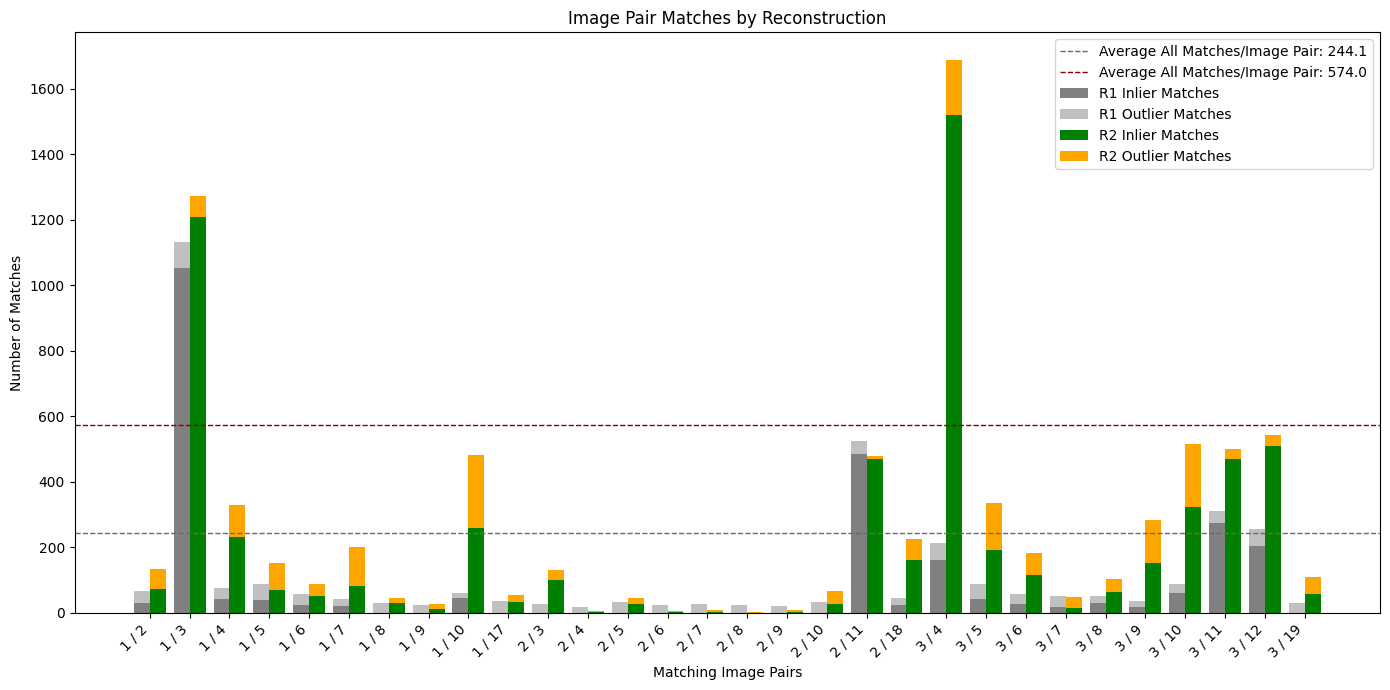

In [27]:
# generate barplots for matches

# img_filter: list(int) = only display matches where image id is specific value
def create_matches_plot(cursor1, cursor2, img_filter = None):
    labels = []
    inlier_matches1 = []
    outlier_matches1 = []
    matches1 = []
    inlier_matches2 = []
    outlier_matches2 = []
    matches2 = []

    cursor1.execute("SELECT pair_id, rows FROM matches;")
    for pair_id1, num_matches1 in cursor1.fetchall():
        img1_id1, img2_id1 = pair_id_to_image_ids(pair_id1)
        img1_id1 = int(img1_id1)
        img2_id1 = int(img2_id1)
        # filter out any unwanted matches if necessary
        if img_filter and img1_id1 not in img_filter and img2_id1 not in img_filter:
            continue
        # find matching image pair for r2
        img1_name = get_image_name_from_id(cursor1, img1_id1)
        img2_name = get_image_name_from_id(cursor1, img2_id1)
        img1_id2 = get_image_id_from_name(cursor2, img1_name)
        img2_id2 = get_image_id_from_name(cursor2, img2_name)
        pair_id2 = image_ids_to_pair_id(img1_id2, img2_id2)
        cursor2.execute(f"SELECT rows FROM matches WHERE pair_id={pair_id2};")
        cursor2_result = cursor2.fetchone()
        if not cursor2_result:
            raise Exception("Matching image pair not found")

        num_matches2, = cursor2_result

        # get inliers
        cursor1.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={pair_id1};")
        cursor1_result = cursor1.fetchone()
        num_inlier_matches1 = 0
        if cursor1_result:
            num_inlier_matches1 = cursor1_result[0]

        num_outlier_matches1 = num_matches1 - num_inlier_matches1
        
        cursor2.execute(f"SELECT rows FROM two_view_geometries WHERE pair_id={pair_id2};")
        cursor2_result = cursor2.fetchone()
        num_inlier_matches2 = 0
        if cursor2_result:
            num_inlier_matches2 = cursor2_result[0]

        num_outlier_matches2 = num_matches2 - num_inlier_matches2

        # write data
        #labels.append(f"M {name_part(img1_name)} / {name_part(img2_name)}")
        labels.append(f"{img1_id1} / {img2_id1}")
        outlier_matches1.append(num_outlier_matches1)
        inlier_matches1.append(num_inlier_matches1)
        matches1.append(num_matches1)
        outlier_matches2.append(num_outlier_matches2)
        inlier_matches2.append(num_inlier_matches2)
        matches2.append(num_matches2)

    x_axis = np.asarray(labels)
    #x_axis = np.arange(len(labels), dtype=np.int16)
    y_axis = {
        "Outlier Matches": np.asarray(outlier_matches1),
        "Inlier Matches": np.asarray(inlier_matches1),
        "Matches": np.asarray(matches1)
    }
    y_axis2 = {
        "Outlier Matches": np.asarray(outlier_matches2),
        "Inlier Matches": np.asarray(inlier_matches2),
        "Matches": np.asarray(matches2)
    }

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(14, 7))
    rects1 = ax.bar(x - width/2, y_axis['Inlier Matches'], width, label='R1 Inlier Matches', color='gray')
    rects2 = ax.bar(x - width/2, y_axis['Outlier Matches'], width, bottom=y_axis['Inlier Matches'], label='R1 Outlier Matches', color='silver')
    rects3 = ax.bar(x + width/2, y_axis2['Inlier Matches'], width, label='R2 Inlier Matches', color='green')
    rects4 = ax.bar(x + width/2, y_axis2['Outlier Matches'], width, bottom=y_axis2['Inlier Matches'], label='R2 Outlier Matches', color='orange')

    r1_analysis = run_sfm_analysis(r1_cursor, r1_pts)
    mean1 = r1_analysis['matches']['avg']
    ax.axhline(
        y=mean1, 
        color = 'dimgray',
        linestyle = '--', 
        linewidth = 1,
        label = f'Average All Matches/Image Pair: {mean1}'
    )
    r2_analysis = run_sfm_analysis(r2_cursor, r2_pts)
    mean2 = r2_analysis['matches']['avg']
    ax.axhline(
        y=mean2, 
        color = 'darkred',
        linestyle = '--', 
        linewidth = 1,
        label = f'Average All Matches/Image Pair: {mean2}'
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Matching Image Pairs')
    ax.set_ylabel('Number of Matches')
    ax.set_title('Image Pair Matches by Reconstruction')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.legend()

    # Optional: Add average lines and other analysis if necessary

    fig.tight_layout()

    return fig, ax

    # r1
    ax[0].bar(x_axis, y_axis['Inlier Matches'], label='Inlier Matches', color='green', width=0.8, align='center')
    ax[0].bar(x_axis, y_axis['Outlier Matches'], bottom=y_axis['Inlier Matches'], label='Outlier Matches', color='orange', width=0.8, align='center')
    #mean1 = np.nanmean(y_axis['Matches'])
    r1_analysis = run_sfm_analysis(r1_cursor, r1_pts)
    mean1 = r1_analysis['matches']['avg']
    ax[0].axhline(
        y=mean1, 
        color = 'r',
        linestyle = '--', 
        linewidth = 1,
        label = f'Average All Matches/Image Pair: {mean1}'
    )
    # r2
    ax[1].bar(x_axis, y_axis2['Inlier Matches'], label='Inlier Matches', color='green', width=0.8, align='center')
    ax[1].bar(x_axis, y_axis2['Outlier Matches'], bottom=y_axis2['Inlier Matches'], label='Outlier Matches', color='orange', width=0.8, align='center')
    #mean2 = np.nanmean(y_axis2['Matches'])
    r2_analysis = run_sfm_analysis(r2_cursor, r2_pts)
    mean2 = r2_analysis['matches']['avg']
    ax[1].axhline(
        y=mean2, 
        color = 'r',
        linestyle = '--', 
        linewidth = 1,
        label = f'Average All Matches/Image Pair: {mean2}'
    )

    ax[0].set_title("Reconstruction 1 Image Pair Matches")
    ax[0].legend()
    ax[0].set_xlabel('Matching Image Pairs')
    ax[0].set_ylabel('Number of Matches')

    ax[1].set_title("Reconstruction 2 Image Pair Matches")
    ax[1].legend()
    ax[1].set_xlabel('Matching Image Pairs')
    ax[1].set_ylabel('Number of Matches')
    
    return fig, ax

plot = create_matches_plot(r1_cursor, r2_cursor, [1,2,3])
#plt.rcParams["figure.figsize"] = (21,14)
plt.show()

In [25]:
from numpy.linalg import svd

def kabsch_algorithm(P, Q):
    """
    Compute the optimal rotation matrix that aligns P to Q.
    
    Parameters:
    - P: An array of aligned camera centers from the first reconstruction.
    - Q: An array of aligned camera centers from the second reconstruction.
    
    Returns:
    - The optimal rotation matrix.
    """
    # Compute the covariance matrix
    C = np.dot(np.transpose(P), Q)
    
    # Perform Singular Value Decomposition
    V, _, W = svd(C)
    
    # Ensure a right-handed coordinate system
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0
    if d:
        S = np.diag([1, 1, -1])
    else:
        S = np.eye(3)
    
    # Compute the rotation matrix
    R = np.dot(np.dot(V, S), W)
    
    return R

def apply_rotation(poses, R):
    """
    Rotate the camera centers in poses by the rotation matrix R.
    
    Parameters:
    - poses: Dictionary of poses.
    - R: Rotation matrix.
    
    Returns:
    - Rotated poses.
    """
    rotated_poses = {}
    for order_id, (qvec, tvec, image_name, image_id) in poses.items():
        rotated_translation = np.dot(R, tvec)
        rotated_poses[order_id] = (qvec, tuple(rotated_translation), image_name, image_id)
    return rotated_poses

def compute_translation(poses1, poses2):
    """
    Compute the translation vector needed to align poses2 with poses1.
    
    Parameters:
    - poses1: Dictionary of the first set of poses.
    - poses2: Dictionary of the second set of poses, already rotated.
    
    Returns:
    - The translation vector.
    """
    translations1 = np.array([translation for _, translation, _, _ in poses1.values()])
    translations2 = np.array([translation for _, translation, _, _ in poses2.values()])
    
    # The translation vector is the difference in centroids
    centroid1 = np.mean(translations1, axis=0)
    centroid2 = np.mean(translations2, axis=0)
    
    translation_vector = centroid1 - centroid2
    return translation_vector

def extract_transformation(images_model):
    # quaternion rotation = qvec = (qw, qx, qy, qz)
    # translation = tvec = (tx, ty, tz)
    poses = {}
    for image_id, image in images_model.items():
        poses[image_id] = (image.qvec, image.tvec, image.name, int(image.id))
    # returns: (qvec, tvec, name)
    return poses

def compute_centroid(poses):
    """
    Compute the centroid of camera positions.
    
    Parameters:
    - poses: Dictionary of poses with translation components.
    
    Returns:
    - Centroid of the camera positions.
    """
    positions = [translation for _, translation, _, _ in poses.values()]
    return np.mean(positions, axis=0)

def align_centroids(poses, centroid):
    """
    Translate poses to align the centroid with the origin.
    
    Parameters:
    - poses: Dictionary of poses.
    - centroid: The centroid to align to the origin.
    
    Returns:
    - Translated poses.
    """
    aligned_poses = {}
    for order_id, (qvec, tvec, image_name, image_id) in poses.items():
        aligned_translation = np.array(tvec) - centroid
        aligned_poses[order_id] = (qvec, tuple(aligned_translation), image_name, image_id)
    return aligned_poses

def align_pose_indicies(poses1, poses2):
    if len(poses1) == len(poses2):
        return poses1, poses2

    sorted_poses1 = {}
    sorted_poses2 = {}
    # assumption that poses1 contains at lease the same poses as poses2!
    order_id = 0
    for _, poses1_pose in poses1.items():
        qvec, tvec, image_name, image_id = poses1_pose
        image2_id = get_image_id_from_name(r2_cursor, image_name)
        if not image2_id:
            # skip missing poses
            continue
        #print(image_id, image2_id)
        if image2_id not in poses2.keys():
            # skip missing poses
            continue
        poses2_matching_pose = poses2[image2_id]
        sorted_poses1[order_id] = poses1_pose
        sorted_poses2[order_id] = poses2_matching_pose
        order_id += 1
    assert len(sorted_poses1) == len(sorted_poses2)
    return (sorted_poses1, sorted_poses2)

def align_r2():
    # load poses
    r1_poses = extract_transformation(r1_imgs)
    r2_poses = extract_transformation(r2_imgs)
    #return r1_poses, r2_poses
    r1_poses, r2_poses = align_pose_indicies(r1_poses, r2_poses)
    
    # Compute centroids for both reconstructions
    r1_centroid = compute_centroid(r1_poses)
    r2_centroid = compute_centroid(r2_poses)
    
    # Align centroids of both sets to the origin
    r1_poses_aligned = align_centroids(r1_poses, r1_centroid)
    r2_poses_aligned = align_centroids(r2_poses, r2_centroid)
    
    # Prepare data for Kabsch algorithm (extract aligned camera center positions)
    P = np.array([translation for order_id, (_, translation, _, _) in r1_poses_aligned.items()])
    Q = np.array([translation for order_id, (_, translation, _, _) in r2_poses_aligned.items()])
    
    # Apply the Kabsch algorithm to find the optimal rotation matrix
    R = kabsch_algorithm(P, Q)
    
    # Apply the rotation to the second set of aligned poses
    r2_poses_rotated = apply_rotation(r2_poses_aligned, R)
    
    # Compute the translation vector needed to align the rotated r2 poses with r1 poses
    translation_vector = compute_translation(r1_poses_aligned, r2_poses_rotated)
    
    # Apply this translation to the rotated r2 poses to complete the alignment
    r2_poses_aligned_and_translated = {order_id: (quaternion, tuple(np.array(translation) + translation_vector)) for order_id, (quaternion, translation, image_name, img_id) in r2_poses_rotated.items()}
    return r1_poses, r2_poses_aligned_and_translated

r1_poses, r2_poses = align_r2()

[7.52, 3.13, 4.83, 4.14, 5.59, 6.08, 6.53, 12.37, 8.3, 6.55, 9.86, 6.24, 13.51, 11.57, 8.18, 4.3, 8.18, 4.35, 8.17, 7.94, 5.68]
7.286666666666666


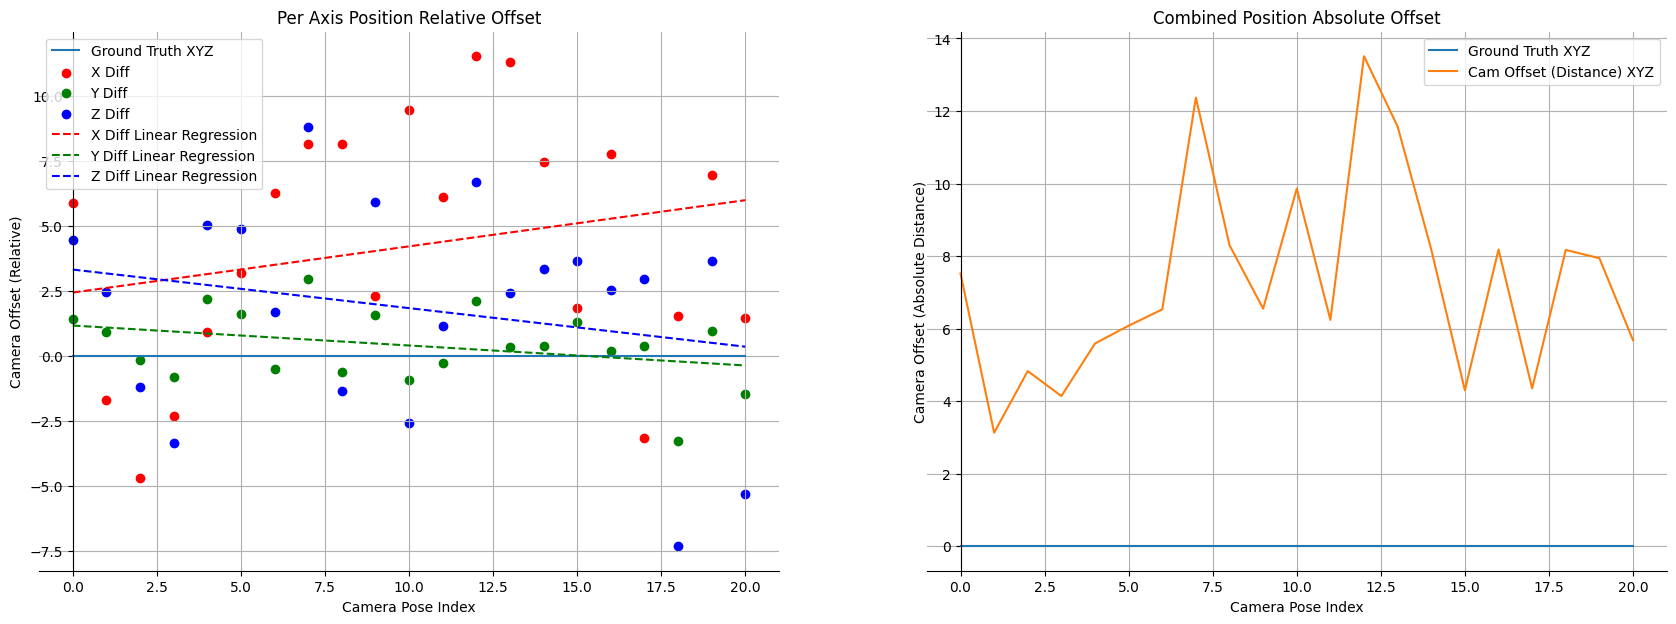

In [26]:
# camera poses translation and rotation offsets

def generate_cam_offset_plot(r1_poses, r2_poses):
    # get tvec of both reconstructions
    r1_positions = [r1p[1][1] for r1p in r1_poses.items()]
    r2_positions = [r2p[1][1] for r2p in r2_poses.items()]
    assert len(r1_positions) == len(r2_positions)
    r2_offsets = [round(euclidean_distance(r1_positions[i], r2_positions[i]), 2) for i, e in enumerate(r1_positions)]
    print(r2_offsets)
    print(np.nanmean(np.asarray(r2_offsets)))
    
    index_array = np.arange(0, len(r2_positions), 1, dtype=int)
    # axis index x=0, y=1, z=2
    r1_x_axis = np.asarray([p[0] for p in r1_positions])
    r1_y_axis = np.asarray([p[1] for p in r1_positions])
    r1_z_axis = np.asarray([p[2] for p in r1_positions])
    
    r2_x_axis = np.asarray([p[0] for p in r2_positions])
    r2_y_axis = np.asarray([p[1] for p in r2_positions])
    r2_z_axis = np.asarray([p[2] for p in r2_positions])
    
    # Create a figure and axes object
    fig, ax = plt.subplots(1,2) #plt.subplots()

    r2_x_axis_diff = r1_x_axis - r2_x_axis
    r2_y_axis_diff = r1_y_axis - r2_y_axis
    r2_z_axis_diff = r1_z_axis - r2_z_axis

    ### PLOT 1: SEPARATE AXIS ###
    # Plot the ground truth XYZ axis reference
    ax[0].plot(index_array, np.zeros_like(index_array), label='Ground Truth XYZ')
    # Plot the difference for each axis separate
    ax[0].scatter(index_array, r2_x_axis_diff, label='X Diff', color='red')
    ax[0].scatter(index_array, r2_y_axis_diff, label='Y Diff', color='green')
    ax[0].scatter(index_array, r2_z_axis_diff, label='Z Diff', color='blue')

    # Fit a linear regression for each difference axis using numpy.polyfit
    slope_x, intercept_x = np.polyfit(index_array, r2_x_axis_diff,  1)
    slope_y, intercept_y = np.polyfit(index_array, r2_y_axis_diff,  1)
    slope_z, intercept_z = np.polyfit(index_array, r2_z_axis_diff,  1)
    
    # Plot the linear regression lines
    x_fit = np.linspace(index_array.min(), index_array.max(),  100)
    y_fit_x = slope_x * x_fit + intercept_x
    y_fit_y = slope_y * x_fit + intercept_y
    y_fit_z = slope_z * x_fit + intercept_z
    
    ax[0].plot(x_fit, y_fit_x, label='X Diff Linear Regression', color='red', linestyle='--')
    ax[0].plot(x_fit, y_fit_y, label='Y Diff Linear Regression', color='green', linestyle='--')
    ax[0].plot(x_fit, y_fit_z, label='Z Diff Linear Regression', color='blue', linestyle='--')

    # Add labels and legend
    ax[0].set_xlabel('Camera Pose Index')
    ax[0].set_ylabel('Camera Offset (Relative)')
    ax[0].legend()
    ax[0].set_title("Per Axis Position Relative Offset")
    # Grid the plot
    ax[0].grid(True, which='both')
    # Set the position of the left and bottom spines to 'zero'
    ax[0].spines['left'].set_position('zero')
    ax[0].spines['top'].set_position('zero')
    # Turn off the right and top spines
    ax[0].spines['right'].set_color('none')
    ax[0].spines['top'].set_color('none')

    ### PLOT 2: COMBINED OFFSET ###
    # Plot the ground truth XYZ axis reference
    ax[1].plot(index_array, np.zeros_like(index_array), label='Ground Truth XYZ')
    ax[1].plot(index_array, r2_offsets, label='Cam Offset (Distance) XYZ')

    # Add labels and legend
    ax[1].set_xlabel('Camera Pose Index')
    ax[1].set_ylabel('Camera Offset (Absolute Distance)')
    ax[1].legend()
    ax[1].set_title("Combined Position Absolute Offset")
    # Grid the plot
    ax[1].grid(True, which='both')
    # Set the position of the left and bottom spines to 'zero'
    ax[1].spines['left'].set_position('zero')
    ax[1].spines['top'].set_position('zero')
    # Turn off the right and top spines
    ax[1].spines['right'].set_color('none')
    ax[1].spines['top'].set_color('none')

    # Set the aspect ratio of the plot to be equal
    #ax.set_aspect('equal')
    return fig, ax

#generate_cam_offset_plot()
cam_off_plt = generate_cam_offset_plot(r1_poses, r2_poses)
plt.rcParams["figure.figsize"] = (21,7)
plt.show()

# Manual Visual Analysis and Comparison

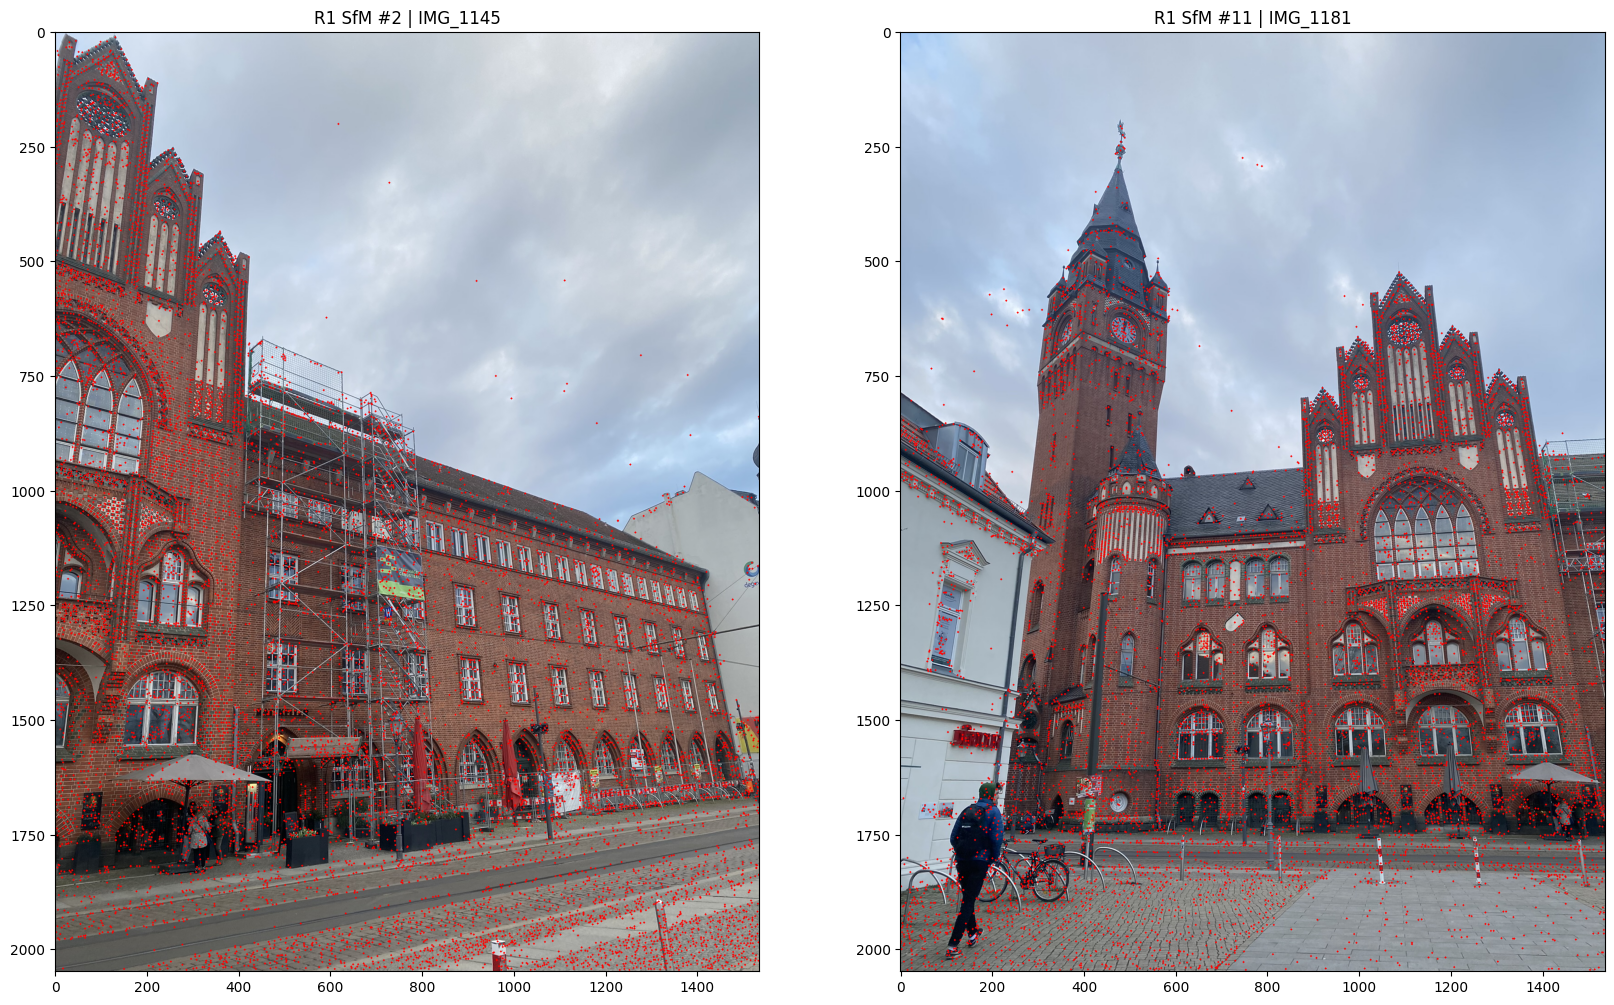

In [28]:
# Display Features for 2 Separate Images

# get image ids of comparing images
r1_img_name1 = get_image_name_from_id(r1_cursor, 2) #"IMG_1221"
r1_img_name2 = get_image_name_from_id(r1_cursor, 11) #"IMG_1231"
r1_img_id1 = get_image_id_from_name(r1_cursor, r1_img_name1)
r1_img_id2 = get_image_id_from_name(r1_cursor, r1_img_name2)

# get image data from ids
r1_image1 = read_image_by_id(r1_cursor, r1_img_id1, GROUND_TRUTH_PATH)
r1_image2 = read_image_by_id(r1_cursor, r1_img_id2, GROUND_TRUTH_PATH)

# get kps for both images
r1_kps1 = get_keypoints(r1_cursor, r1_img_id1)
for i, kpc in enumerate(r1_kps1["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r1_image1, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

r1_kps2 = get_keypoints(r1_cursor, r1_img_id2)
for i, kpc in enumerate(r1_kps2["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r1_image2, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

# convert images to OpenCV images
r1_RGB_img1 = cv2.cvtColor(r1_image1, cv2.COLOR_BGR2RGB)
r1_RGB_img2 = cv2.cvtColor(r1_image2, cv2.COLOR_BGR2RGB)

# draw graph
plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(r1_RGB_img1)
axarr[0].set_title(f"R1 SfM #{r1_img_id1} | {r1_img_name1}")
axarr[1].imshow(r1_RGB_img2)
axarr[1].set_title(f"R1 SfM #{r1_img_id2} | {r1_img_name2}")

plt.show()

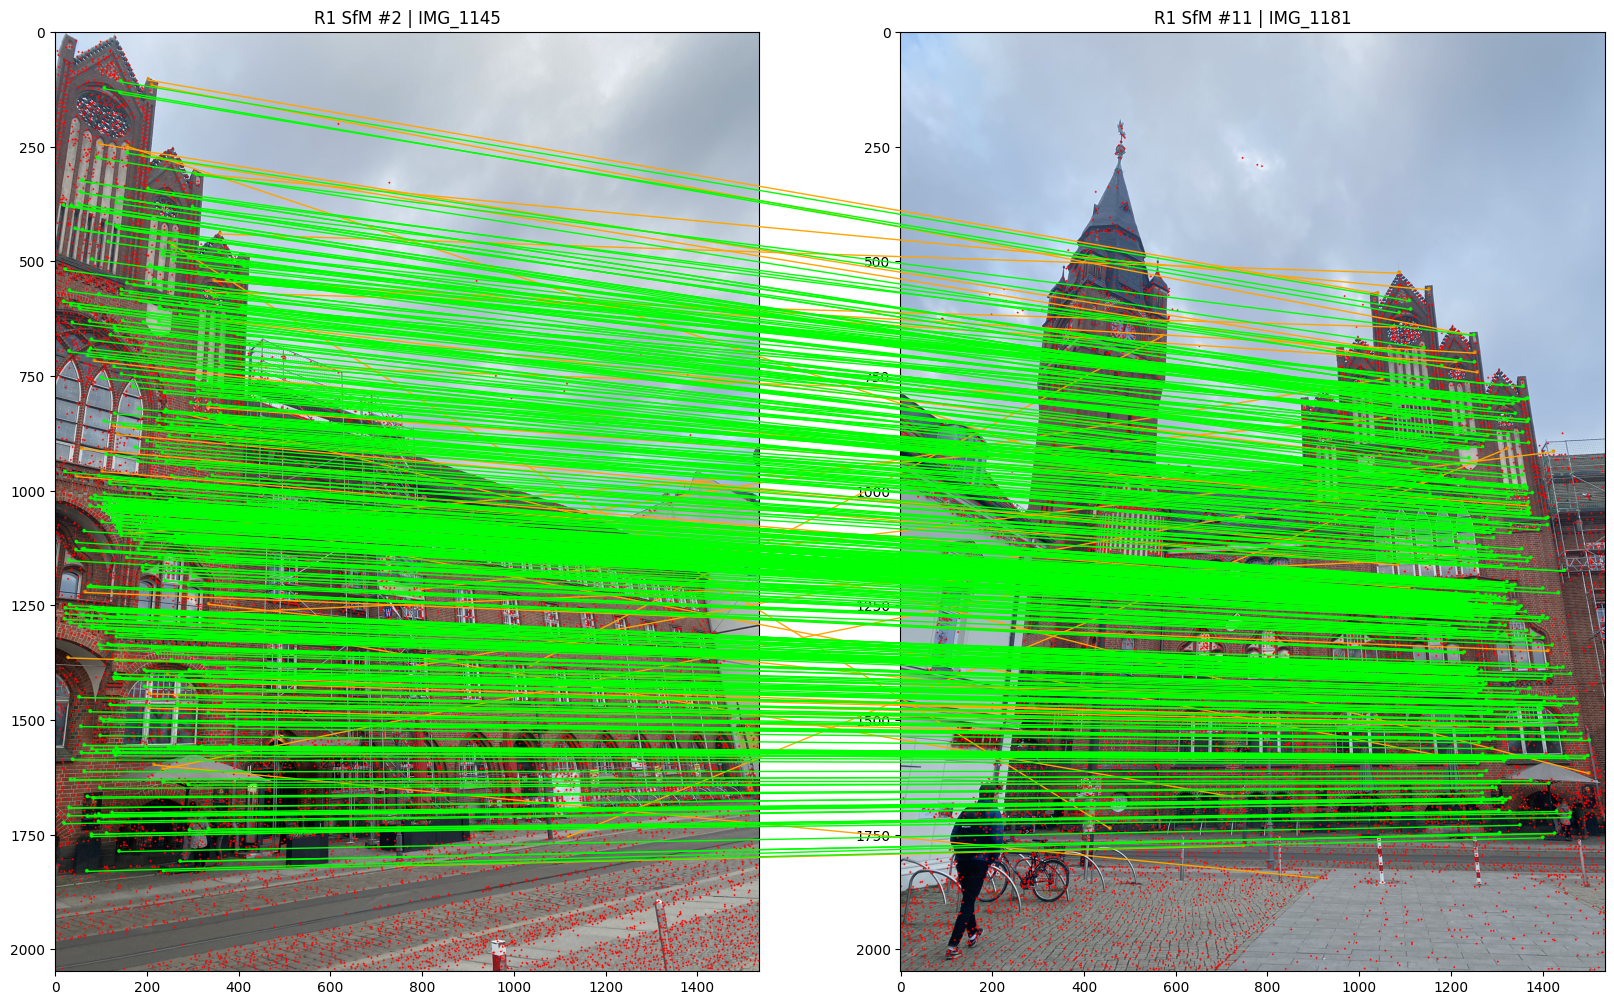

In [29]:
# Display Matched Features on Top (with option of connecting lines between features in images)
from matplotlib.patches import ConnectionPatch

# get inlier and outlier matches
outlier_matches = get_outlier_matches(r1_cursor, r1_img_id1, r1_img_id2)
inlier_matches = get_inlier_matches(r1_cursor, r1_img_id1, r1_img_id2)

def draw_points(matches, color, image1, image2):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        radius = 4
        cv2.circle(image1, (int(kpc1_x), int(kpc1_y)), radius=radius, color=color, thickness=-1)
        cv2.circle(image2, (int(kpc2_x), int(kpc2_y)), radius=radius, color=color, thickness=-1)
    return

def draw_lines(matches, color, plt_array, figure):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        
        # Create a connection patch between the two subplots
        con = ConnectionPatch(xyA=(kpc1_x, kpc1_y), xyB=(kpc2_x, kpc2_y),
                                coordsA="data", coordsB="data",
                                axesA=plt_array[0], axesB=plt_array[1], color=color)
        # Add the connection patch to the figure, not the axes
        figure.add_artist(con)
    return

if len(outlier_matches) != 0:
    #raise Exception("No shared feature matches between both images!")

    # get inlier and outlier points coordinates
    outlier_matches_coords = get_matches_coords(r1_cursor, outlier_matches)
    inlier_matches_coords = get_matches_coords(r1_cursor, inlier_matches)

    draw_points(outlier_matches_coords["image_matches"], (0,  133,  219), r1_image1, r1_image2)
    draw_points(inlier_matches_coords["image_matches"], (0,  255,  0), r1_image1, r1_image2)

r1_RGB_img1 = cv2.cvtColor(r1_image1, cv2.COLOR_BGR2RGB)
r1_RGB_img2 = cv2.cvtColor(r1_image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
axarr[0].imshow(r1_RGB_img1)
axarr[0].set_title(f"R1 SfM #{r1_img_id1} | {r1_img_name1}")
axarr[1].imshow(r1_RGB_img2)
axarr[1].set_title(f"R1 SfM #{r1_img_id2} | {r1_img_name2}")

if len(outlier_matches) != 0:
    # Loop through each keypoint pair and draw lines
    draw_lines(outlier_matches_coords["image_matches"], "orange", axarr, fig)
    draw_lines(inlier_matches_coords["image_matches"], "lime", axarr, fig)

plt.show()

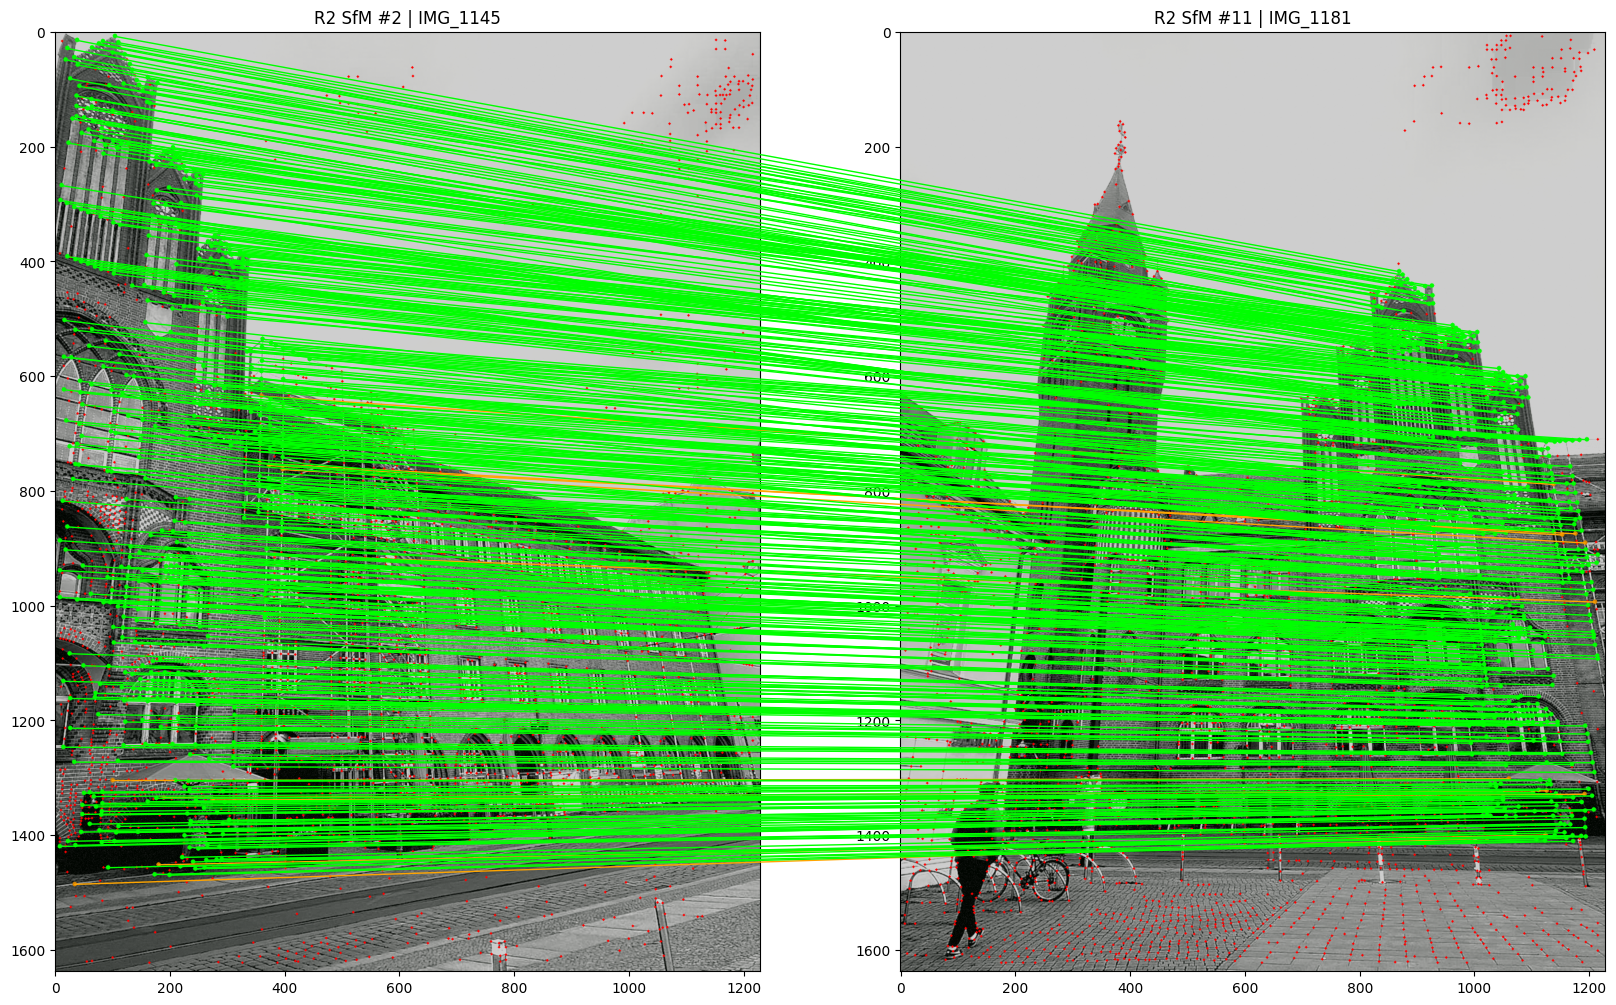

In [30]:
# get image ids of comparing images
# get same names as in reconstruction 1
r2_img_name1 = r1_img_name1
r2_img_name2 = r1_img_name2
r2_img_id1 = get_image_id_from_name(r2_cursor, r2_img_name1)
r2_img_id2 = get_image_id_from_name(r2_cursor, r2_img_name2)

if not r2_img_id1 or not r2_img_id2:
    raise Exception("Could not get image ids in comparison")

# get image data from ids
r2_image1 = read_image_by_id(r2_cursor, r2_img_id1, COMPARISON_PATH)
r2_image2 = read_image_by_id(r2_cursor, r2_img_id2, COMPARISON_PATH)


r2_kps1 = get_keypoints(r2_cursor, r2_img_id1)
for i, kpc in enumerate(r2_kps1["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r2_image1, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

r2_kps2 = get_keypoints(r2_cursor, r2_img_id2)
for i, kpc in enumerate(r2_kps2["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(r2_image2, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

outlier_matches_comp = get_outlier_matches(r2_cursor, r2_img_id1, r2_img_id2)
inlier_matches_comp = get_inlier_matches(r2_cursor, r2_img_id1, r2_img_id2)

if len(outlier_matches_comp) != 0:
    #raise Exception("No shared feature matches between both images!")

    outlier_matches_comp_coords = get_matches_coords(r2_cursor, outlier_matches_comp)
    inlier_matches_comp_coords = get_matches_coords(r2_cursor, inlier_matches_comp)
    
    draw_points(outlier_matches_comp_coords["image_matches"], (0,  133,  219), r2_image1, r2_image2)
    draw_points(inlier_matches_comp_coords["image_matches"], (0,  255,  0), r2_image1, r2_image2)

r2_RGB_img1 = cv2.cvtColor(r2_image1, cv2.COLOR_BGR2RGB)
r2_RGB_img2 = cv2.cvtColor(r2_image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig_comp, axarr_comp = plt.subplots(1,2)
axarr_comp[0].imshow(r2_RGB_img1)
axarr_comp[0].set_title(f"R2 SfM #{r2_img_id1} | {r2_img_name1}")
axarr_comp[1].imshow(r2_RGB_img2)
axarr_comp[1].set_title(f"R2 SfM #{r2_img_id2} | {r2_img_name2}")

if len(outlier_matches_comp) != 0:
    # Loop through each keypoint pair and draw lines
    draw_lines(outlier_matches_comp_coords["image_matches"], "orange", axarr_comp, fig_comp)
    draw_lines(inlier_matches_comp_coords["image_matches"], "lime", axarr_comp, fig_comp)

plt.show()